**Group 007-13 Project Proposal**

**Introduction**
The data set we chose is a tennis data set. We chose to keep specific columns in order to remove irrelevant data and keep the most important columns. We decided to keep if they are right or left handed, their current ranking, the player's name, their backhand throw, their current elo rank, and their prize money. A player's current elo rank is an estimate of their strength and is affected by their wins and loses. We are wondering whether a players bankhand throw and whether they are left or right handed affects their overall success. We will evaluate this by using their backhand, handedness, current rank, and current elo rank. 

**Preliminary exploratory data analysis**
*In code cells below, demonstrate that data can be read into R and then follow the instructions on Canvas*

In [1]:
#prepping data

set.seed(5555)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

download.file("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", "tennis_data.csv")
tennis_data <- read_csv("tennis_data.csv", show_col_types = FALSE)
#tennis_data

winner_data <- tennis_data |> select(winner_age, winner_ht, winner_rank_points) |> na.omit()
loser_data <-  tennis_data |> select(loser_age, loser_ht, loser_rank_points) |> na.omit()

winner_split <- initial_split(winner_data, prop = .75, strata = winner_rank_points)  
winner_train <- training(winner_split)
winner_test <- testing(winner_split)
#winner_train

loser_split <- initial_split(loser_data, prop = .75, strata = loser_rank_points)  
loser_train <- training(loser_split)
loser_test <- testing(loser_split)
#loser_train

win_age_plot <- ggplot(winner_train, aes(x = winner_age, y = winner_rank_points)) +
    geom_point() +
    labs(title = "Age vs Rank Points", x = "Age", y = "Rank Points")
#win_age_plot

lose_age_plot <- ggplot(loser_train, aes(x = loser_age, y = loser_rank_points)) +
    geom_point() +
    labs(title = "Age vs Rank Points", x = "Age", y = "Rank Points")
#lose_age_plot

win_height_plot <- ggplot(winner_train, aes(x = winner_ht, y = winner_rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points", x = "Height", y = "Rank Points")
#win_height_plot

lose_height_plot <- ggplot(loser_train, aes(x = loser_ht, y = loser_rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points", x = "Height", y = "Rank Points")
#lose_height_plot

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
533,rmse,standard,2082.839,5,26.72798,Preprocessor1_Model05


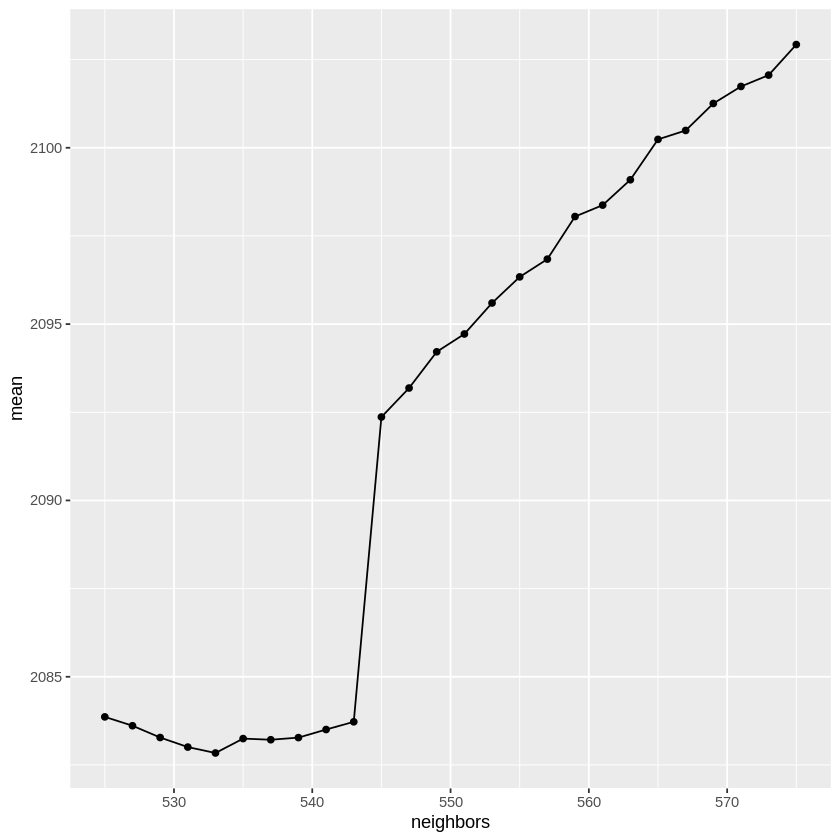

In [2]:
#testing/tuning regression
#k = 527 - v = 5 mean = 2080.262

win_recipe <- recipe(winner_rank_points ~ winner_ht, data = winner_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

win_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

win_workflow <- workflow() |>
  add_recipe(win_recipe) |>
  add_model(win_spec)
#win_workflow

win_vfold <- vfold_cv(winner_train, v = 5, strata = winner_rank_points)

gridvals <- tibble(neighbors = seq(from = 525, to = 575, by = 2))

win_results <- win_workflow |>
  tune_grid(resamples = win_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
#win_results

win_min <- win_results |>
  filter(mean == min(mean))
win_min

k_selec <- ggplot(win_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_selec

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
417,rmse,standard,1341.766,5,59.88494,Preprocessor1_Model08


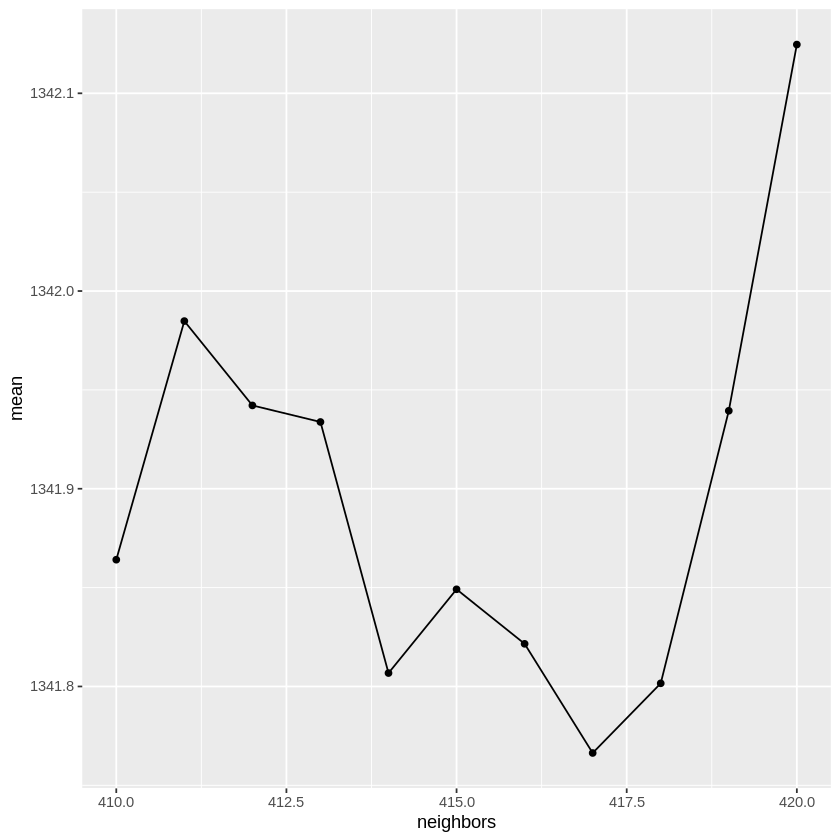

In [7]:
# k = 417 - v = 5 - mean = 1341.766

lose_recipe <- recipe(loser_rank_points ~ loser_ht, data = loser_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

lose_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

lose_workflow <- workflow() |>
  add_recipe(lose_recipe) |>
  add_model(lose_spec)
#win_workflow

lose_vfold <- vfold_cv(loser_train, v = 5, strata = loser_rank_points)

gridvals <- tibble(neighbors = seq(from = 410, to = 420, by = 1))

lose_results <- lose_workflow |>
  tune_grid(resamples = lose_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
#win_results

lose_min <- lose_results |>
  filter(mean == min(mean))
lose_min

k_selec <- ggplot(lose_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_selec

**Methods**
*Explain how you will conduct either your data analysis and which variables/columns you will use.
Describe at least one way that you will visualize the results*

**Expected outcomes and significance** *Answer questions on Canvas*